In [225]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from lightgbm import LGBMClassifier

In [226]:
train_df = pd.read_csv('../input/titanic/train.csv')
test_df = pd.read_csv('../input/titanic/test.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [227]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [228]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- 3/12 columns missing values
- 5/12 columns need type conversion
- 38 % Survived., so accuracy will be a reasonable metric to evaluate our model.
- Survived is target
- PassengerId is just incremental index, it does not convery any information
- Too many value missings in Cabin, may we omit this field ?

## Data Visualization

In [229]:
train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [230]:
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [231]:
train_df['Cabin'].value_counts()

G6             4
C23 C25 C27    4
B96 B98        4
E101           3
C22 C26        3
              ..
C90            1
D15            1
A20            1
C86            1
A6             1
Name: Cabin, Length: 147, dtype: int64

In [232]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [233]:
train_df['Ticket'].value_counts()

1601                 7
CA. 2343             7
347082               7
347088               6
3101295              6
                    ..
C 7077               1
STON/O 2. 3101285    1
2669                 1
28424                1
349241               1
Name: Ticket, Length: 681, dtype: int64

<AxesSubplot:xlabel='Age', ylabel='Count'>

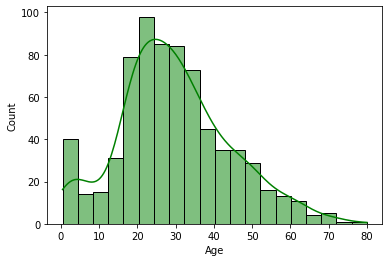

In [234]:
sns.histplot(x=train_df['Age'],kde=True,bins=20,color='g')

<AxesSubplot:xlabel='Fare', ylabel='Count'>

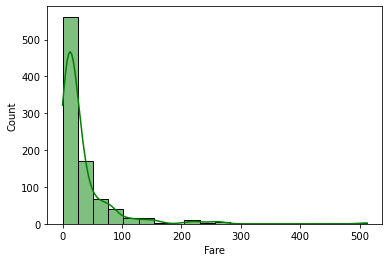

In [235]:
sns.histplot(x=train_df['Fare'],kde=True,bins=20,color='g')

In [236]:
train_df['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [237]:
train_df['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

## Data Processing

- Member: create new feature which is the count of family number
- Age: Fill N/A with mean of grouping by number of member Family
- Fare: Fill NA with median of grouping by Ticket class, take the log to regularize outlier
- Cabin, fillna with 'N' and take first letter
- Ticket, fillna with 'X', split string and take first split
- Embarked, fillna with 'N' value

In [238]:
fare_map = train_df[['Fare', 'Pclass']].dropna().groupby('Pclass').median().to_dict()
train_df['Fare'] = train_df['Fare'].fillna(train_df['Pclass'].map(fare_map['Fare']))
test_df['Fare'] = test_df['Fare'].fillna(test_df['Pclass'].map(fare_map['Fare']))

In [239]:
train_df['Member'] = train_df['SibSp'] + train_df['Parch'] +1
test_df['Member'] = test_df['SibSp'] + test_df['Parch'] + 1

In [240]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].mean())

In [241]:
train_df['Cabin'] = train_df['Cabin'].fillna('N').map(lambda x: x[0].strip())
test_df['Cabin'] = test_df['Cabin'].fillna('N').map(lambda x: x[0].strip())

In [242]:
train_df['Ticket'] = train_df['Ticket'].map(len)
test_df['Ticket'] = test_df['Ticket'].map(len)

In [243]:
train_df['Embarked'] = train_df['Embarked'].fillna('N')
test_df['Embarked'] = test_df['Embarked'].fillna('N')

In [244]:
label_col = ['Pclass', 'Sex', 'Cabin', 'Embarked']

lc = LabelEncoder()
for col in label_col:
    train_df[col] = lc.fit_transform(train_df[col])
    test_df[col] = lc.transform(test_df[col])

In [245]:
num_col = ['Age','Fare','Member']
sc = StandardScaler()
train_df[features] = sc.fit_transform(train_df[features])
test_df[features] = sc.transform(test_df[features])

### Tuning paramater

In [246]:
features = label_col + num_col
train = train_df[features]
test = test_df[features]
target = train_df['Survived']
X_train, X_val, y_train, y_val = train_test_split(train, target, test_size= 0.2)

In [247]:
param_grid = {"C":np.logspace(-3,3,7), "max_iter": np.linspace(100,500,10)} 
logreg = LogisticRegression()
grid_search = GridSearchCV(logreg,param_grid,cv=10,n_jobs=10)
grid_search.fit(X_train,y_train)
print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'max_iter': 100.0}
accuracy : 0.7935446009389671


In [248]:
logit_clf = LogisticRegression(C=0.01,max_iter=100).fit(X_train, y_train)
logit_clf.score(X_val, y_val)

0.8268156424581006

In [249]:
param_grid = [
        {'kernel': ['rbf'], 'C': [1.0, 3.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0]},
    ]

svm_reg = SVC()
grid_search = GridSearchCV(svm_reg, param_grid, cv=10, scoring='accuracy', verbose=2,n_jobs=10)
grid_search.fit(X_train,y_train)
print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.0s


tuned hpyerparameters :(best parameters)  {'C': 3.0, 'gamma': 0.1, 'kernel': 'rbf'}
accuracy : 0.818838028169014


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


In [250]:
svm_clf = SVC(C=1.0,gamma=1.0,kernel='rbf',probability=True).fit(X_train, y_train)
svm_clf.score(X_val, y_val)

0.8491620111731844

In [251]:
param_grid = [
    {'n_estimators': [100, 200, 300,400,500],'max_depth': [40,60,80], 'min_samples_split': [30,40,50], 'min_samples_leaf': [20,30,40]}
  ]

forest_clf = RandomForestClassifier()
grid_search = GridSearchCV(forest_clf, param_grid, cv=10,scoring='accuracy',n_jobs=10)
grid_search.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 80, 'min_samples_leaf': 20, 'min_samples_split': 40, 'n_estimators': 200}
accuracy : 0.8117370892018778


In [252]:
forest_clf = RandomForestClassifier(max_depth=40,min_samples_leaf=20,min_samples_split=50,n_estimators=300).fit(X_train, y_train)
forest_clf.score(X_val, y_val)

0.8156424581005587

In [253]:
param_grid = [
    {'metric': ["binary_logloss"],'n_estimators':[1200],'objective': ['binary'],
     'learning_rate':[0.01,0.05,0.1],
     'colsample_bytree': [0.3,0.4,0.5],
      'min_child_samples': [300],'max_depth': [50,60,70,80,90],'num_leaves': [30,40,50,60,70]}]

lgbm_clf = LGBMClassifier()
grid_search = GridSearchCV(lgbm_clf, param_grid, cv=10,scoring='accuracy',n_jobs=10)
grid_search.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 50, 'metric': 'binary_logloss', 'min_child_samples': 300, 'n_estimators': 1200, 'num_leaves': 30, 'objective': 'binary'}
accuracy : 0.6206964006259781


In [254]:
lgbm_clf = LGBMClassifier().fit(X_train, y_train)
lgbm_clf.score(X_val, y_val)

0.8156424581005587

In [255]:
voting_clf = VotingClassifier(
    estimators=[('lr', logit_clf),('svm',svm_clf), ('fr',forest_clf),('lgbm',lgbm_clf)],
    voting='soft').fit(X_train, y_train)

In [214]:
voting_clf.score(X_val, y_val)

0.8603351955307262

In [215]:
y_pred = voting_clf.predict(test)
submission = pd.DataFrame({
        "PassengerId": test_df['PassengerId'],
        "Survived": y_pred
    })

submission.to_csv('../output/titanic.csv', index=False)